Используя схемы переменных направлений и дробных шагов, решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, y, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h_x$, $h_y$.

In [390]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Дифференциальное уравнение:

$$
\frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2} + a \frac{\partial^2 u}{\partial y^2}, \quad a > 0
$$

Граничные и начальные условия:

\
\begin{cases}
u(0, y, t) = \cosh(y) \cdot e^{-3 a t} \\
u\left(\frac{\pi}{4}, y, t\right) = 0 \\
u(x, 0, t) = \cos(2x) \cdot e^{-3 a t} \\
u(x, \ln 2, t) = \frac{5}{4} \cos(2x) \cdot e^{-3 a t} \\
u(x, y, 0) = \cos(2x) \cdot \cosh(y)
\end{cases}
\

Аналитическое решение:

$$
u(x, y, t) = \cos(2x) \cdot \cosh(y) \cdot e^{-3 a t}
$$

In [441]:
# ===== Параметры задачи =====
a = 1.0
Xmax, Ymax = np.pi/4, np.log(2)
Nx, Ny = 100, 100
Tfinal = 0.1
Nt = 100
hx = Xmax / Nx
hy = Ymax / Ny
tau = Tfinal / Nt

x = np.linspace(0, Xmax, Nx+1)
y = np.linspace(0, Ymax, Ny+1)
X, Y = np.meshgrid(x, y, indexing='ij')

# ===== Аналитическое решение =====
def u_exact(x, y, t):
    return np.cos(2*x) * np.cosh(y) * np.exp(-3*a*t)

# ===== Граничные условия =====
def apply_bc(u, t):
    # по x: левый (x=0) и правый (x=Xmax=pi/4)
    u[0, :] = np.cosh(y) * np.exp(-3*a*t)   # x=0
    u[-1, :] = 0.0                           # x=pi/4, Dirichlet 0

    # по y: нижняя (y=0) и верхняя (y=ln2) — новая система: верхнее Dirichlet
    u[:, 0] = np.cos(2*x) * np.exp(-3*a*t)      # y=0
    u[:, -1] = 1.25 * np.cos(2*x) * np.exp(-3*a*t)  # y=ln2, 5/4 = 1.25

    return u

In [392]:
def solve_tridiagonal_lu(a, b, c, d):
    n = len(d)

    # Инициализация матриц L и U
    l = np.zeros(n)    # нижняя диагональ L
    u_main = np.zeros(n)  # главная диагональ U
    u_upper = np.zeros(n-1)  # верхняя диагональ U

    # LU-разложение
    u_main[0] = b[0]
    u_upper[0] = c[0]

    for i in range(1, n):
        l[i] = a[i] / u_main[i-1]
        u_main[i] = b[i] - l[i] * u_upper[i-1]
        if i < n-1:
            u_upper[i] = c[i]

    # Прямая подстановка (Ly = d)
    y = np.zeros(n)
    y[0] = d[0]
    for i in range(1, n):
        y[i] = d[i] - l[i] * y[i-1]

    # Обратная подстановка (Ux = y)
    x = np.zeros(n)
    x[n-1] = y[n-1] / u_main[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - u_upper[i] * x[i+1]) / u_main[i]

    return x

### Пошаговый вывод схемы переменных направлений (ADI)

**Шаг A. Исходное уравнение**

$$
\frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2} + a \frac{\partial^2 u}{\partial y^2}, \quad a > 0
$$

с начальными и граничными условиями:

\begin{equation*}
\begin{cases}
u(0, y, t) = \sinh(y) e^{-3 a t} \\
u(\pi/2, y, t) = -\sinh(y) e^{-3 a t} \\
u(x, 0, t) = \cos(2x) e^{-3 a t} \\
u(x, \ln 2, t) = \frac{5}{4} \cos(2x) e^{-3 a t} \\
u(x, y, 0) = \cos(2x) \sinh(y)
\end{cases}
\end{equation*}

---

**Шаг B. Сеточная дискретизация**

Разбиваем область на равномерную сетку:

$$
x_i = i h_x, \quad y_j = j h_y, \quad t^n = n \tau
$$

$$
h_x = \frac{\pi/4}{N_x}, \quad h_y = \frac{\ln 2}{N_y}, \quad \tau = \frac{T_{final}}{N_t}
$$

Сетка: $u^n_{i,j} \approx u(x_i, y_j, t^n)$.

---

**Шаг C. Дискретизация второго порядка (центральные разности)**

$$
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1,j} - 2 u_{i,j} + u_{i-1,j}}{h_x^2}, \quad
\frac{\partial^2 u}{\partial y^2} \approx \frac{u_{i,j+1} - 2 u_{i,j} + u_{i,j-1}}{h_y^2}
$$

---

**Шаг D. Разделение на полушаги (ADI)**

1. Первый полушаг (неявный по $x$, явный по $y$):

$$
\frac{u^*_{i,j} - u^n_{i,j}}{\tau/2} = a \frac{u^*_{i+1,j} - 2 u^*_{i,j} + u^*_{i-1,j}}{h_x^2} + a \frac{u^n_{i,j+1} - 2 u^n_{i,j} + u^n_{i,j-1}}{h_y^2}
$$

2. Второй полушаг (неявный по $y$, явный по $x$):

$$
\frac{u^{n+1}_{i,j} - u^*_{i,j}}{\tau/2} = a \frac{u^*_{i+1,j} - 2 u^*_{i,j} + u^*_{i-1,j}}{h_x^2} + a \frac{u^{n+1}_{i,j+1} - 2 u^{n+1}_{i,j} + u^{n+1}_{i,j-1}}{h_y^2}
$$

---

**Шаг E. Преобразование в трёхдиагональные системы**

- Для каждого $j$ (по $x$) решаем систему:

$$
- r_x u^*_{i-1,j} + (1+2 r_x) u^*_{i,j} - r_x u^*_{i+1,j} = r_y u^n_{i,j-1} + (1-2 r_y) u^n_{i,j} + r_y u^n_{i,j+1}
$$

где $r_x = a\tau/(2 h_x^2), \quad r_y = a\tau/(2 h_y^2)$.

- Для каждого $i$ (по $y$) решаем систему:

$$
- r_y u^{n+1}_{i,j-1} + (1+2 r_y) u^{n+1}_{i,j} - r_y u^{n+1}_{i,j+1} = r_x u^*_{i-1,j} + (1-2 r_x) u^*_{i,j} + r_x u^*_{i+1,j}
$$

---

**Шаг F. Граничные условия на каждом полушаге**

- Подставляем значения на границах $i=0, i=N_x, j=0, j=N_y$.

---

**Шаг G. Итоговая формула**

После решения трёхдиагональных систем на каждом полушаге получаем численное решение:

$$
u^{n+1}_{i,j} \approx u(x_i, y_j, t^{n+1})
$$

<!-- Эта схема **второго порядка по $x$, $y$ и времени**, устойчива для больших шагов времени. -->

**Схема переменных направлений**

In [393]:
def adi_step(u, tau, hx, hy, a):
    Nx, Ny = u.shape[0]-1, u.shape[1]-1
    r_x = a*tau/(2*hx**2)
    r_y = a*tau/(2*hy**2)
    u_star = u.copy()

    a_x = np.full(Nx+1, -r_x)       # нижняя диагональ
    b_x = np.full(Nx+1, 1 + 2*r_x)  # главная диагональ
    c_x = np.full(Nx+1, -r_x)       # верхняя диагональ

    # Граничные условия Дирихле по X
    a_x[0] = 0; b_x[0] = 1; c_x[0] = 0
    a_x[Nx] = 0; b_x[Nx] = 1; c_x[Nx] = 0

    # Шаг 1: X-направление
    for j in range(1, Ny):
        d = np.zeros(Nx+1)
        for i in range(1, Nx):
            d[i] = r_y*u[i,j-1] + (1-2*r_y)*u[i,j] + r_y*u[i,j+1]
        d[0] = u[0,j]    # Граничные условия
        d[Nx] = u[Nx,j]  # Граничные условия

        u_star[:,j] = solve_tridiagonal_lu(a_x, b_x, c_x, d)

    u_new = u_star.copy()

    a_y = np.full(Ny+1, -r_y)       # нижняя диагональ
    b_y = np.full(Ny+1, 1 + 2*r_y)  # главная диагональ
    c_y = np.full(Ny+1, -r_y)       # верхняя диагональ

    # Граничные условия Дирихле по Y
    a_y[0] = 0; b_y[0] = 1; c_y[0] = 0
    a_y[Ny] = 0; b_y[Ny] = 1; c_y[Ny] = 0

    # Шаг 2: Y-направление
    for i in range(1, Nx):
        d = np.zeros(Ny+1)
        for j in range(1, Ny):
            d[j] = r_x*u_star[i-1,j] + (1-2*r_x)*u_star[i,j] + r_x*u_star[i+1,j]
        d[0] = u_star[i,0]    # Граничные условия
        d[Ny] = u_star[i,Ny]  # Граничные условия

        u_new[i,:] = solve_tridiagonal_lu(a_y, b_y, c_y, d)

    return u_new

### Пошаговый вывод схемы дробных шагов

**Шаг A. Исходное уравнение**

$$
\frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2} + a \frac{\partial^2 u}{\partial y^2}, \quad a > 0
$$

с теми же начальными и граничными условиями.

---

**Шаг B. Сеточная дискретизация**

$$
x_i = i h_x, \quad y_j = j h_y, \quad t^n = n \tau
$$

---

**Шаг C. Неявный шаг по $x$, явный по $y$ (LOD)**

$$
\frac{u^*_{i,j} - u^n_{i,j}}{\tau} = a \frac{u^*_{i+1,j} - 2 u^*_{i,j} + u^*_{i-1,j}}{h_x^2} + a \frac{u^n_{i,j+1} - 2 u^n_{i,j} + u^n_{i,j-1}}{h_y^2}
$$

---

**Шаг D. Неявный шаг по $y$, явный по $x$**

$$
\frac{u^{n+1}_{i,j} - u^*_{i,j}}{\tau} = a \frac{u^*_{i+1,j} - 2 u^*_{i,j} + u^*_{i-1,j}}{h_x^2} + a \frac{u^{n+1}_{i,j+1} - 2 u^{n+1}_{i,j} + u^{n+1}_{i,j-1}}{h_y^2}
$$

---

**Шаг E. Трёхдиагональные системы**

- По $x$:

$$
- r_x u^*_{i-1,j} + (1+2 r_x) u^*_{i,j} - r_x u^*_{i+1,j} = u^n_{i,j} + r_y (u^n_{i,j-1} - 2 u^n_{i,j} + u^n_{i,j+1})
$$

- По $y$:

$$
- r_y u^{n+1}_{i,j-1} + (1+2 r_y) u^{n+1}_{i,j} - r_y u^{n+1}_{i,j+1} = u^*_{i,j} + r_x (u^*_{i-1,j} - 2 u^*_{i,j} + u^*_{i+1,j})
$$

---

**Шаг F. Граничные условия**

Применяются на каждом шаге, как и в ADI.

---

**Шаг G. Итоговая формула**

$$
u^{n+1}_{i,j} \approx u(x_i, y_j, t^{n+1})
$$

<!-- LOD также **второго порядка по пространству и первого порядка по времени**, но проще в реализации. -->

**Схема дробных шагов**

In [394]:
def lod_step(u, tau, hx, hy, a):
    Nx, Ny = u.shape[0]-1, u.shape[1]-1
    r_x = a*tau/hx**2
    r_y = a*tau/hy**2
    u_star = u.copy()

    # === Шаг 1: неявный по X ===
    a_x = np.full(Nx+1, -r_x)
    b_x = np.full(Nx+1, 1 + 2*r_x)
    c_x = np.full(Nx+1, -r_x)

    # Граничные условия по X
    a_x[0] = 0; b_x[0] = 1; c_x[0] = 0
    a_x[Nx] = 0; b_x[Nx] = 1; c_x[Nx] = 0

    for j in range(1, Ny):
        d = np.zeros(Nx+1)
        for i in range(1, Nx):
            d[i] = u[i,j]
        d[0] = u[0,j]
        d[Nx] = u[Nx,j]

        u_star[:,j] = solve_tridiagonal_lu(a_x, b_x, c_x, d)

    u_new = u_star.copy()

    # === Шаг 2: неявный по Y ===
    a_y = np.full(Ny+1, -r_y)
    b_y = np.full(Ny+1, 1 + 2*r_y)
    c_y = np.full(Ny+1, -r_y)

    # Граничные условия по Y
    a_y[0] = 0; b_y[0] = 1; c_y[0] = 0
    a_y[Ny] = 0; b_y[Ny] = 1; c_y[Ny] = 0

    for i in range(1, Nx):
        d = np.zeros(Ny+1)
        for j in range(1, Ny):
            d[j] = u_star[i,j]
        d[0] = u_star[i,0]
        d[Ny] = u_star[i,Ny]

        u_new[i,:] = solve_tridiagonal_lu(a_y, b_y, c_y, d)

    u_new = apply_bc(u_new, 0)
    return u_new

In [442]:
# ===== Основной цикл =====
u_adi = np.zeros((Nx+1, Ny+1))
u_lod = np.zeros((Nx+1, Ny+1))
u_adi = apply_bc(u_adi, 0)
u_lod = apply_bc(u_lod, 0)

N_plot = 20
times_to_plot = [int(n * Nt / (N_plot-1)) for n in range(N_plot)]
solutions_adi = []
solutions_lod = []

for n in range(1,Nt+1):
    u_adi = adi_step(u_adi, tau, hx, hy, a)
    u_adi = apply_bc(u_adi, n*tau)
    u_lod = lod_step(u_lod, tau, hx, hy, a)
    u_lod = apply_bc(u_lod, n*tau)
    if n in times_to_plot:
        solutions_adi.append((n*tau, u_adi.copy()))
        solutions_lod.append((n*tau, u_lod.copy()))


In [443]:
# ===== Вывод погрешностей =====
print("Проверка точности численных схем:")
for (t_adi, u_adi_snap), (t_lod, u_lod_snap) in zip(solutions_adi, solutions_lod):
    u_exact_snap = u_exact(X, Y, t_adi)
    err_adi = np.max(np.abs(u_adi_snap - u_exact_snap))
    err_lod = np.max(np.abs(u_lod_snap - u_exact_snap))
    print(f"T = {t_adi:.3f} | max |ADI-Exact| = {err_adi:.3e} | max |LOD-Exact| = {err_lod:.3e}")

# ===== Вычисление ошибок =====
max_errors_adi = []
max_errors_lod = []

u_adi = np.zeros((Nx+1, Ny+1))
u_lod = np.zeros((Nx+1, Ny+1))
u_adi = apply_bc(u_adi, 0)
u_lod = apply_bc(u_lod, 0)

times = np.linspace(0, Tfinal, Nt+1)

for n, t in enumerate(times):
    if n > 0:
        u_adi = adi_step(u_adi, tau, hx, hy, a)
        u_adi = apply_bc(u_adi, t)
        u_lod = lod_step(u_lod, tau, hx, hy, a)
        u_lod = apply_bc(u_lod, t)
    error_adi = np.max(np.abs(u_adi - u_exact(X,Y,t)))
    error_lod = np.max(np.abs(u_lod - u_exact(X,Y,t)))
    max_errors_adi.append(error_adi)
    max_errors_lod.append(error_lod)

Проверка точности численных схем:
T = 0.005 | max |ADI-Exact| = 9.376e-01 | max |LOD-Exact| = 9.241e-01
T = 0.010 | max |ADI-Exact| = 8.019e-01 | max |LOD-Exact| = 7.946e-01
T = 0.015 | max |ADI-Exact| = 6.784e-01 | max |LOD-Exact| = 6.756e-01
T = 0.021 | max |ADI-Exact| = 5.460e-01 | max |LOD-Exact| = 5.468e-01
T = 0.026 | max |ADI-Exact| = 4.535e-01 | max |LOD-Exact| = 4.557e-01
T = 0.031 | max |ADI-Exact| = 3.764e-01 | max |LOD-Exact| = 3.792e-01
T = 0.036 | max |ADI-Exact| = 3.125e-01 | max |LOD-Exact| = 3.153e-01
T = 0.042 | max |ADI-Exact| = 2.502e-01 | max |LOD-Exact| = 2.528e-01
T = 0.047 | max |ADI-Exact| = 2.080e-01 | max |LOD-Exact| = 2.103e-01
T = 0.052 | max |ADI-Exact| = 1.729e-01 | max |LOD-Exact| = 1.749e-01
T = 0.057 | max |ADI-Exact| = 1.438e-01 | max |LOD-Exact| = 1.455e-01
T = 0.063 | max |ADI-Exact| = 1.153e-01 | max |LOD-Exact| = 1.166e-01
T = 0.068 | max |ADI-Exact| = 9.587e-02 | max |LOD-Exact| = 9.696e-02
T = 0.073 | max |ADI-Exact| = 7.970e-02 | max |LOD-Exact

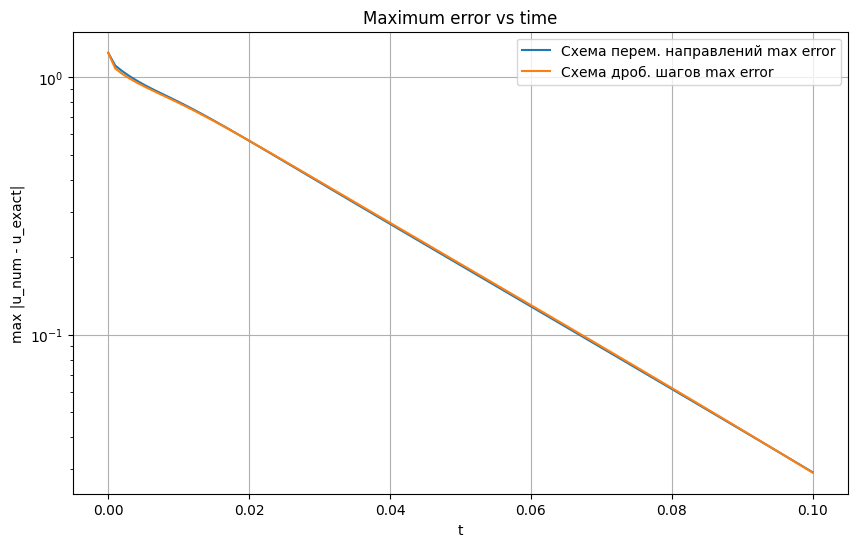

In [444]:
# ===== 1. График max error по времени =====
plt.figure(figsize=(10,6))
plt.plot(times, max_errors_adi, label='Схема перем. направлений max error')
plt.plot(times, max_errors_lod, label='Схема дроб. шагов max error')
plt.yscale('log')  # удобно на логарифмической шкале
plt.xlabel('t'); plt.ylabel('max |u_num - u_exact|')
plt.title('Maximum error vs time')
plt.legend()
plt.grid(True)
plt.show()

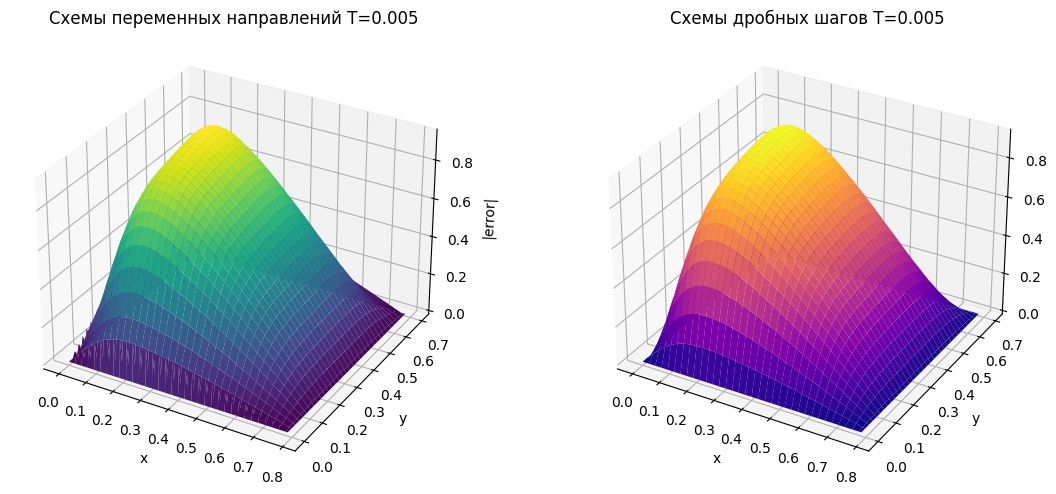

In [446]:
# ===== 2. 3D график ошибки =====
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

index = 0

t_for_graph_adi, u_for_graph_adi = solutions_adi[index]
t_for_graph_lod, u_for_graph_lod = solutions_lod[index]

error_for_graph_adi = np.abs(u_for_graph_adi - u_exact(X,Y,t_for_graph_adi))
error_for_graph_lod = np.abs(u_for_graph_lod - u_exact(X,Y,t_for_graph_lod))

ax1.plot_surface(X, Y, error_for_graph_adi, cmap='viridis')
ax1.set_title(f'Схемы переменных направлений T={t_for_graph_adi}')
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('|error|')

ax2.plot_surface(X, Y, error_for_graph_lod, cmap='plasma')
ax2.set_title(f'Схемы дробных шагов T={t_for_graph_lod}')
ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('|error|')

plt.tight_layout()
plt.show()

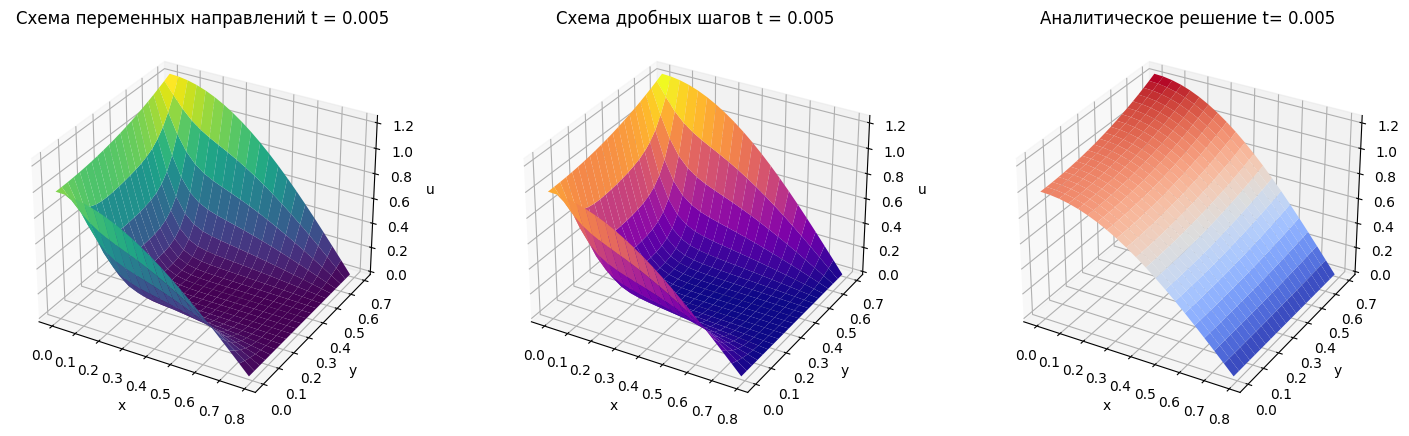

In [438]:
# ===== 1. 3D график ADI + LOD + аналитика =====
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

ax1.plot_surface(X, Y, u_for_graph_adi, cmap='viridis')
ax1.set_title(f'Схема переменных направлений t = {t_for_graph_adi}')
ax2.plot_surface(X, Y, u_for_graph_lod, cmap='plasma')
ax2.set_title(f'Схема дробных шагов t = {t_for_graph_lod}')
ax3.plot_surface(X, Y, u_exact(X, Y, t_for_graph_adi), cmap='coolwarm')
ax3.set_title(f'Аналитическое решение t= {t_for_graph_lod}')

ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')
ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')
ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('u')

# plt.tight_layout()
plt.show()

In [417]:
# ===== 2. 2D график ADI vs аналитика =====
def plot_2d_adi(solutions_adi, y_coord = Ny//2):
    plt.figure(figsize=(10,6))
    for t, u in solutions_adi:
        plt.plot(x, u[:,y_coord], label=f"Сх.п.н T={t:.3f}")
        plt.plot(x, u_exact(x, y[y_coord], t), 'k--', label=f"Exact T={t:.3f}" if t==solutions_adi[0][0] else "")
    plt.title(f"Схема переменных направлений vs Analytic along y={round(y[y_coord], 3)}")
    plt.xlabel('x'); plt.ylabel('u'); plt.legend()
    plt.show()

In [418]:
# ===== 3. 2D график LOD vs аналитика =====
def plot_2d_lod(solutions_lod, y_coord = Ny//2):
    plt.figure(figsize=(10,6))
    for t, u in solutions_lod:
        plt.plot(x, u[:,y_coord], label=f"Сх.д.щ T={t:.3f}")
        plt.plot(x, u_exact(x, y[y_coord], t), 'k--', label=f"Exact T={t:.3f}" if t==solutions_lod[0][0] else "")
    plt.title(f"Схема дробных шагов vs Analytic along y={round(y[y_coord], 3)}")
    plt.xlabel('x'); plt.ylabel('u'); plt.legend()
    plt.show()

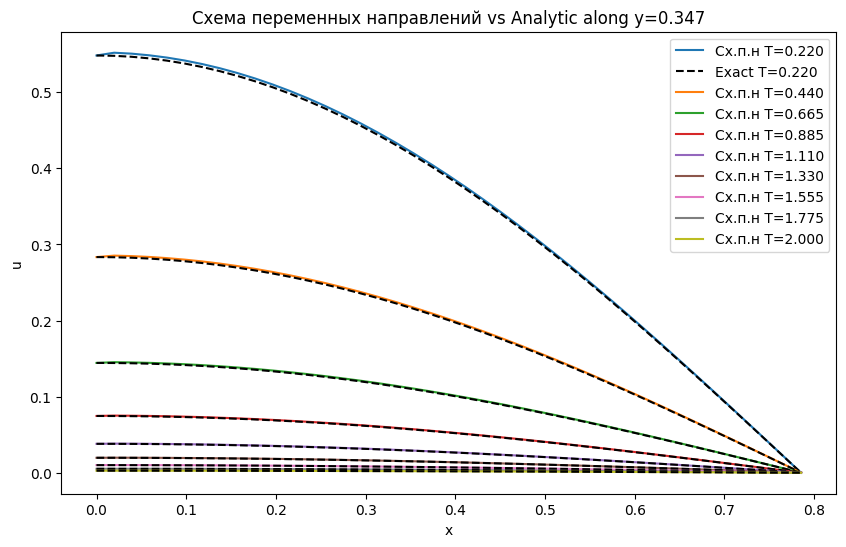

In [419]:
plot_2d_adi(solutions_adi)

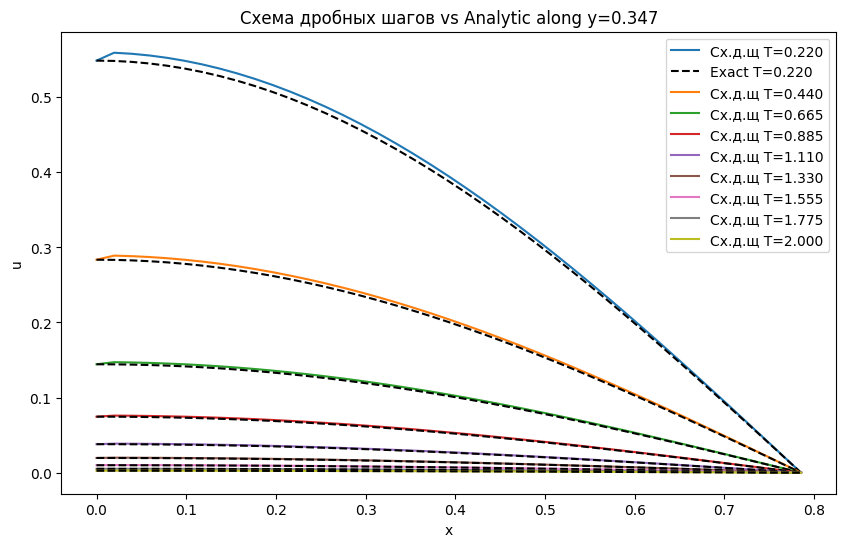

In [420]:
plot_2d_lod(solutions_lod)